In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf

In [2]:
# Show all columns
pd.set_option('display.max_columns', None)

In [3]:
# Import banking data

# Each record describes characteristics of a client
client = pd.read_csv("./data/raw/data_berka/client.asc", sep=';')

# Each record describes static characteristics of an account
account = pd.read_csv("./data/raw/data_berka/account.asc", sep=';')

# Each record describes a credit card issued to an account
card = pd.read_csv("./data/raw/data_berka/card.asc", sep=';')

# Each record describes demographic characteristics of a district
district = pd.read_csv("./data/raw/data_berka/district.asc", sep=';')

# Each record relates together a client with an account
# i.e. this relation describes the rights of clients to operate accounts
disp = pd.read_csv("./data/raw/data_berka/disp.asc", sep=';')

# Each record describes characteristics of a payment order (debits only)
order = pd.read_csv("./data/raw/data_berka/order.asc", sep=';')

# Each record describes one transaction on an account
trans = pd.read_csv("./data/raw/data_berka/trans.asc", sep=';', low_memory=False)

# Each record describes a loan granted for a given account
loan = pd.read_csv("./data/raw/data_berka/loan.asc", sep=';')

# CLIENT TABLE

In [4]:
client

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5
...,...,...,...
5364,13955,456030,1
5365,13956,430406,1
5366,13968,680413,61
5367,13971,626019,67


In [5]:
# Checking for the null values inside the client table
client.isna().sum()

client_id       0
birth_number    0
district_id     0
dtype: int64

In [6]:
# Client Birth Year
client['birth_year'] = 1900 + client['birth_number'].astype(str).str[:2].astype(int)
client['birth_year'] = client['birth_year'].astype(int)

# Client Birth Month
client['birth_month'] = client['birth_number'].astype(str).str[2:4].astype(int)

# Client Birth Day
client['birth_day'] = client['birth_number'].astype(str).str[-2:].astype(int)

# Client Gender
client['gender'] = 'Male'
client.loc[client['birth_month'] > 50, 'gender'] = 'Female'

# Client Age
client['client_age'] = 1996 - client['birth_year']

# Correct the birth month
client.loc[client['birth_month'] > 50, 'birth_month'] = client.loc[client['birth_month'] > 50, 'birth_month'] - 50

# Age group
client['age_group'] = client['client_age'] // 10 * 10
client.head()

# Client Date of Birth
client["DOB"] = client["birth_day"].astype(str).str[:] + "-" + client["birth_month"].astype(str).str[:] + "-" + client["birth_year"].astype(str).str[:]
client

# dropping the unwanted columns 
# dropping the birth_number 
client = client.drop(['birth_number'], axis =1)

client

,client_id,district_id,birth_year,birth_month,birth_day,gender,client_age,age_group,DOB
0,1,18,1970,12,13,Female,26,20,13-12-1970
1,2,1,1945,2,4,Male,51,50,4-2-1945
2,3,1,1940,10,9,Female,56,50,9-10-1940
3,4,5,1956,12,1,Male,40,40,1-12-1956
4,5,5,1960,7,3,Female,36,30,3-7-1960
...,...,...,...,...,...,...,...,...,...
5364,13955,1,1945,10,30,Female,51,50,30-10-1945
5365,13956,1,1943,4,6,Male,53,50,6-4-1943
5366,13968,61,1968,4,13,Male,28,20,13-4-1968
5367,13971,67,1962,10,19,Female,34,30,19-10-1962


In [7]:
# checking for thr outliers in the age 
print(client["client_age"].max())
print(client["client_age"].min())

85
9


# ACCOUNT TABLE

In [8]:
# Checking for the null values inside the account table
account.isna().sum()

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

In [9]:
# Find the client account openning date
account['acc_open_year'] = 1900 + account['date'].astype(str).str[:2].astype(int)

# Getting the data of accounts before 1996
account = account[account['acc_open_year'] < 1996].copy(deep=True)

# Find the client age at the year they open bank account
account['client_age_opening'] = account['acc_open_year'] - client['birth_year']
account['client_age_opening'].astype(int)

# LOR
# Add length of relationship in year
account['lor'] = 1996 - account['acc_open_year']

account

,account_id,district_id,frequency,date,acc_open_year,client_age_opening,lor
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3
...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,27.0,1
2235,3814,74,POPLATEK MESICNE,951227,1995,21.0,1
2236,2780,63,POPLATEK MESICNE,951229,1995,48.0,1
2237,3273,74,POPLATEK MESICNE,951229,1995,24.0,1


In [10]:
# Number of accounts district wise
acctdis = account.groupby('district_id')['account_id'].count()

# Number of accounts age wise
acctagecreate = account.groupby('client_age_opening')['account_id'].count()

#year wise account opening
acctyear = account.groupby('acc_open_year')['account_id'].count()

# Frequency 
acctfreq = account.groupby('frequency')['account_id'].count()

# DISP Table

In [11]:
disp.isna().sum()

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

In [12]:
#Getting only the owners
disp_owner = disp[disp['type'] == 'OWNER']

In [13]:
#Number of cards linked with per accounts
q = disp.groupby('account_id')['disp_id'].count()

In [14]:
# Getting the whole data of the owners
df_disp_account = pd.merge(account, disp_owner, how = 'left' , on = 'account_id')
df_disp_account

,account_id,district_id,frequency,date,acc_open_year,client_age_opening,lor,disp_id,client_id,type
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3,692,692,OWNER
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3,4601,4601,OWNER
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3,844,844,OWNER
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3,2873,2873,OWNER
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3,3177,3177,OWNER
...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,27.0,1,5384,5384,OWNER
2235,3814,74,POPLATEK MESICNE,951227,1995,21.0,1,4596,4596,OWNER
2236,2780,63,POPLATEK MESICNE,951229,1995,48.0,1,3357,3357,OWNER
2237,3273,74,POPLATEK MESICNE,951229,1995,24.0,1,3962,3962,OWNER


# District Table

In [15]:
#Check for any null values
district.isna().sum()

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
A16    0
dtype: int64

# ORDER

In [16]:
#Check for any null values
order.isna().sum()

order_id      0
account_id    0
bank_to       0
account_to    0
amount        0
k_symbol      0
dtype: int64

# TRANSACTIONS

In [17]:
# Checking for the null values
trans.isna().sum()

trans_id           0
account_id         0
date               0
type               0
operation     183114
amount             0
balance            0
k_symbol      481881
bank          782812
account       760931
dtype: int64

In [18]:
# Replacing the null values of operations with 0
trans['without_operation']=0
trans.loc[trans['operation'].isna() ,'without_operation']=1
trans['operation'] = trans['operation'].fillna(0)

# Replacing the null values of transaction with 0
trans['without_k_symbol']=0
trans.loc[trans['k_symbol'].isna() ,'without_k_symbol']=1
trans['k_symbol'] = trans['k_symbol'].fillna(0)

#Getting the year for trans
trans["trans_year"] = 1900 + trans["date"].astype(str).str[:2].astype(int) 
# Getting the Month
trans["trans_month"] = trans["date"].astype(str).str[2:4]

# Getting the data for 1996 only
trans = trans[trans['trans_year'] == 1996]

# Drop unused columns
trans = trans.drop(['bank','account'], axis =1)

trans

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,without_operation,without_k_symbol,trans_year,trans_month
252855,732811,2504,960101,VYDAJ,VYBER KARTOU,900.0,38124.4,0,0,1,1996,01
252856,800209,2729,960101,VYDAJ,VYBER,1920.0,34202.7,0,0,1,1996,01
252857,803553,2738,960101,VYDAJ,VYBER,6500.0,25685.2,0,0,1,1996,01
252858,1042686,3566,960101,VYDAJ,VYBER,1000.0,25919.7,0,0,1,1996,01
252859,1042689,3566,960101,VYDAJ,VYBER,500.0,25419.7,0,0,1,1996,01
...,...,...,...,...,...,...,...,...,...,...,...,...
449629,515914,1763,961231,VYDAJ,VYBER,14.6,67769.5,SLUZBY,0,0,1996,12
449630,516262,1765,961231,VYDAJ,VYBER,14.6,19708.1,SLUZBY,0,0,1996,12
449631,520019,1775,961231,VYDAJ,VYBER,14.6,15944.5,SLUZBY,0,0,1996,12
449632,517894,1769,961231,VYDAJ,VYBER,14.6,34679.4,SLUZBY,0,0,1996,12


In [19]:
# Checking the number of types of transactions
trans.groupby('k_symbol')['trans_id'].count()

# Number of transaction per type
trans.groupby('type')['trans_id'].count()

#Amount of transacations per type
trans.groupby('type')['amount'].sum()

# Number of transaction per operations
trans.groupby('operation')['trans_id'].count()

trans.groupby('operation')['amount'].sum()

operation
0                 5.010410e+06
PREVOD NA UCET    1.195635e+08
PREVOD Z UCTU     1.460159e+08
VKLAD             4.557447e+08
VYBER             4.354881e+08
VYBER KARTOU      2.028900e+06
Name: amount, dtype: float64

### Trans Type

In [20]:
# Aggregate the total credit per account
credit_amount = trans[trans['type'].isin(['PRIJEM'])].groupby('account_id')['amount'].agg('sum')
credit_amount = credit_amount.reset_index()
credit_amount = credit_amount.rename(columns={'amount':'Amount_credit'})
credit_amount

,account_id,Amount_credit
0,1,50066.0
1,2,288542.9
2,4,56920.5
3,6,81507.7
4,7,34905.4
...,...,...
3596,11333,426027.5
3597,11349,551271.3
3598,11359,352777.0
3599,11362,211221.6


In [21]:
# Aggregate the total withdrawal per account
withdrawal_amount = trans[trans['type'].isin(['VYDAJ', 'VYBER'])].groupby('account_id')['amount'].agg('sum')
withdrawal_amount = withdrawal_amount.reset_index()
withdrawal_amount = withdrawal_amount.rename(columns={'amount':'Amount_withdrawal'})
withdrawal_amount

,account_id,Amount_withdrawal
0,1,55579.2
1,2,274574.2
2,4,31977.6
3,6,81803.2
4,7,6600.0
...,...,...
3294,11333,407902.4
3295,11349,542689.0
3296,11359,351816.7
3297,11362,222356.0


In [22]:
# Total number credit transactions per account id
credit_trans = trans[trans['type'].isin(['PRIJEM'])].groupby('account_id')['amount'].agg('count')
credit_trans = credit_trans.reset_index()
credit_trans = credit_trans.rename(columns={'amount':'Number_trans_credit'})
credit_trans

,account_id,Number_trans_credit
0,1,29
1,2,29
2,4,17
3,6,24
4,7,3
...,...,...
3596,11333,43
3597,11349,25
3598,11359,24
3599,11362,24


In [23]:
# Total number withdrawal transactions per account id
withdrawal_trans = trans[trans['type'].isin(['VYDAJ', 'VYBER'])].groupby('account_id')['amount'].agg('count')
withdrawal_trans = withdrawal_trans.reset_index()
withdrawal_trans = withdrawal_trans.rename(columns={'amount':'Number_trans_withdrawal'})
withdrawal_trans

,account_id,Number_trans_withdrawal
0,1,45
1,2,56
2,4,22
3,6,39
4,7,1
...,...,...
3294,11333,45
3295,11349,63
3296,11359,71
3297,11362,78


In [24]:
# Make trans type table
trans_type = pd.merge(credit_amount, withdrawal_amount, how='left', on='account_id')
trans_type = pd.merge(trans_type, credit_trans, how='left', on='account_id')
trans_type = pd.merge(trans_type, withdrawal_trans, how='left', on='account_id')

trans_type

,account_id,Amount_credit,Amount_withdrawal,Number_trans_credit,Number_trans_withdrawal
0,1,50066.0,55579.2,29,45.0
1,2,288542.9,274574.2,29,56.0
2,4,56920.5,31977.6,17,22.0
3,6,81507.7,81803.2,24,39.0
4,7,34905.4,6600.0,3,1.0
...,...,...,...,...,...
3596,11333,426027.5,407902.4,43,45.0
3597,11349,551271.3,542689.0,25,63.0
3598,11359,352777.0,351816.7,24,71.0
3599,11362,211221.6,222356.0,24,78.0


### Trans operation

In [25]:
# Withdrawl Using Credit Card
Credit_Card_withdrawl = trans[trans['operation'].isin(['VYBER KARTOU'])].groupby('account_id',)['amount'].agg('sum')
Credit_Card_withdrawl = Credit_Card_withdrawl.reset_index()
Credit_Card_withdrawl = Credit_Card_withdrawl.rename(columns={'amount':'Credit_Card_withdrawl'})
Credit_Card_withdrawl

,account_id,Credit_Card_withdrawl
0,33,14100.0
1,43,27100.0
2,71,3500.0
3,73,24300.0
4,95,8100.0
...,...,...
169,10227,2700.0
170,10520,10600.0
171,11013,8000.0
172,11042,14500.0


In [26]:
# Credit in cash
Credit_in_cash = trans[trans['operation'].isin(['VKLAD'])].groupby('account_id',)['amount'].agg('sum')
Credit_in_cash = Credit_in_cash.reset_index()
Credit_in_cash = Credit_in_cash.rename(columns={'amount':'Credit_in_cash'})
Credit_in_cash

,account_id,Credit_in_cash
0,1,5100.0
1,2,23500.0
2,4,800.0
3,7,34875.0
4,8,266174.0
...,...,...
2974,11325,84148.0
2975,11328,74772.0
2976,11333,422471.0
2977,11349,3100.0


In [27]:
# Collection from another bank
Collection = trans[trans['operation'].isin(['PREVOD Z UCTU'])].groupby('account_id',)['amount'].agg('sum')
Collection = Collection .reset_index()
Collection = Collection .rename(columns={'amount':'Collection_from_another_bank'})
Collection 

,account_id,Collection_from_another_bank
0,1,44148.0
1,2,263068.0
2,4,55530.0
3,6,80028.0
4,11,41928.0
...,...,...
1235,11186,510210.0
1236,11271,145886.0
1237,11349,545844.0
1238,11359,351182.0


In [28]:
# Withdrawal in cash
Cash_withdrawl = trans[trans['operation'].isin(['VYBER'])].groupby('account_id',)['amount'].agg('sum')
Cash_withdrawl = Cash_withdrawl.reset_index()
Cash_withdrawl = Cash_withdrawl.rename(columns={'amount':'Cash_withdrawl'})
Cash_withdrawl

,account_id,Cash_withdrawl
0,1,26155.2
1,2,187382.2
2,4,13877.6
3,6,34355.2
4,7,6600.0
...,...,...
3294,11333,407902.4
3295,11349,328081.0
3296,11359,259741.2
3297,11362,169406.0


In [29]:
# Remittance to another bank
Remittance = trans[trans['operation'].isin(['PREVOD NA UCET'])].groupby('account_id',)['amount'].agg('sum')
Remittance = Remittance.reset_index()
Remittance = Remittance.rename(columns={'amount':'Remittance_to_another_bank'})
Remittance 

,account_id,Remittance_to_another_bank
0,1,29424.0
1,2,87192.0
2,4,18100.0
3,6,47448.0
4,8,95852.0
...,...,...
2329,11265,37356.0
2330,11271,95568.0
2331,11349,214608.0
2332,11359,79775.5


In [30]:
# Make trans operation table
trans_operation = pd.merge(Credit_Card_withdrawl, Credit_in_cash, how='left', on='account_id')
trans_operation = pd.merge(trans_operation, Collection, how='left', on='account_id')
trans_operation = pd.merge(trans_operation, Cash_withdrawl, how='left', on='account_id')
trans_operation = pd.merge(trans_operation, Remittance, how='left', on='account_id')

trans_operation['Credit_Card_withdrawl'] = trans_operation['Credit_Card_withdrawl'].fillna(0)
trans_operation['Credit_in_cash'] = trans_operation['Credit_in_cash'].fillna(0)
trans_operation['Collection_from_another_bank'] = trans_operation['Collection_from_another_bank'].fillna(0)
trans_operation['Cash_withdrawl'] = trans_operation['Cash_withdrawl'].fillna(0)
trans_operation['Remittance_to_another_bank'] = trans_operation['Remittance_to_another_bank'].fillna(0)

trans_operation

,account_id,Credit_Card_withdrawl,Credit_in_cash,Collection_from_another_bank,Cash_withdrawl,Remittance_to_another_bank
0,33,14100.0,306658.0,0.0,209575.2,46704.0
1,43,27100.0,310804.0,0.0,228195.2,79068.0
2,71,3500.0,282322.0,0.0,229135.2,52308.0
3,73,24300.0,248443.0,0.0,145515.2,72732.0
4,95,8100.0,311050.0,0.0,285235.2,0.0
...,...,...,...,...,...,...
169,10227,2700.0,568933.0,0.0,576428.0,0.0
170,10520,10600.0,36437.0,0.0,71700.0,6959.8
171,11013,8000.0,1200.0,549172.0,375114.0,178008.0
172,11042,14500.0,3600.0,470482.0,260144.2,173613.6


### Trans k_symbol

In [31]:
# insurrance payment
insurrance_payment = trans[trans['k_symbol'].isin(["POJISTNE"])].groupby(['account_id'])['amount'].agg('sum')
insurrance_payment = insurrance_payment.reset_index()
insurrance_payment = insurrance_payment.rename(columns={'amount':'insurrance_payment_payment'})
insurrance_payment

,account_id,insurrance_payment_payment
0,25,492.0
1,29,96.0
2,47,1692.0
3,68,1644.0
4,71,12132.0
...,...,...
334,10694,3900.0
335,10711,85.0
336,10789,2670.0
337,11271,5676.0


In [32]:
# payment for statement
statement_payment = trans[trans['k_symbol'].isin(["SLUZBY"])].groupby(['account_id'])['amount'].agg('sum')
statement_payment = statement_payment.reset_index()
statement_payment = statement_payment.rename(columns={'amount':'statement_payment'})
statement_payment

,account_id,statement_payment
0,1,175.2
1,2,175.2
2,4,87.6
3,6,175.2
4,8,160.6
...,...,...
2960,11333,175.2
2961,11349,360.0
2962,11359,175.2
2963,11362,146.0


In [33]:
# Intrest Credited 
Intrest_Credited = trans[trans['k_symbol'].isin(["UROK"])].groupby('account_id',)['amount'].agg('sum')
Intrest_Credited = Intrest_Credited.reset_index()
Intrest_Credited = Intrest_Credited.rename(columns={'amount':'Intrest_Credited'})
Intrest_Credited

,account_id,Intrest_Credited
0,1,818.0
1,2,1974.9
2,4,590.5
3,6,1479.7
4,7,30.4
...,...,...
3378,11333,3556.5
3379,11349,2327.3
3380,11359,1595.0
3381,11362,1387.6


In [34]:
# sanction interest if negative balance
sanction_intrest = trans[trans['k_symbol'].isin(["SANKC. UROK"])].groupby(['account_id'])['amount'].agg('sum')
sanction_intrest = sanction_intrest.reset_index()
sanction_intrest = sanction_intrest.rename(columns={'amount':'sanction_intrest'})
sanction_intrest

,account_id,sanction_intrest
0,19,1.9
1,245,2.5
2,253,1.6
3,347,22.2
4,377,11.0
...,...,...
62,10365,4.6
63,10788,124.6
64,10904,17.2
65,11333,0.2


In [35]:
# Household Payment
Household_payment = trans[trans['k_symbol'].isin(["SIPO"])].groupby(['account_id'])['amount'].agg('sum')
Household_payment = Household_payment.reset_index()
Household_payment = Household_payment.rename(columns={'amount':'Household_payment'})
Household_payment

,account_id,Household_payment
0,1,29424.0
1,2,87192.0
2,4,10390.0
3,6,47448.0
4,8,28732.0
...,...,...
2177,11271,63888.0
2178,11295,80400.0
2179,11349,130632.0
2180,11359,54216.0


In [36]:
# old-age pension
Pension = trans[trans['k_symbol'].isin(["DUCHOD"])].groupby(['account_id'])['amount'].agg('sum')
Pension = Pension.reset_index()
Pension = Pension.rename(columns={'amount':'Pension_received'})
Pension

,account_id,Pension_received
0,4,55530.0
1,6,80028.0
2,35,65352.0
3,39,77688.0
4,44,50400.0
...,...,...
571,3966,52008.0
572,3976,51624.0
573,3977,55632.0
574,3989,48192.0


In [37]:
# Loan Payment
Loan_payment = trans[trans['k_symbol'].isin(["UVER"])].groupby(['account_id'])['amount'].agg('sum')
Loan_payment = Loan_payment.reset_index()
Loan_payment = Loan_payment.rename(columns={'amount':'Loan_payment'})
Loan_payment

,account_id,Loan_payment
0,19,12616.0
1,67,55320.0
2,132,14740.4
3,290,30924.0
4,344,20196.0
...,...,...
278,11135,60876.0
279,11138,41191.7
280,11186,19623.6
281,11349,83976.0


In [38]:
# Make trans k_symbol table
trans_k_symbol = pd.merge(insurrance_payment, statement_payment, how='left', on='account_id')
trans_k_symbol = pd.merge(trans_k_symbol, Intrest_Credited, how='left', on='account_id')
trans_k_symbol = pd.merge(trans_k_symbol, sanction_intrest, how='left', on='account_id')
trans_k_symbol = pd.merge(trans_k_symbol, Household_payment, how='left', on='account_id')
trans_k_symbol = pd.merge(trans_k_symbol, Pension, how='left', on='account_id')
trans_k_symbol = pd.merge(trans_k_symbol, Loan_payment, how='left', on='account_id')

trans_k_symbol['insurrance_payment_payment'] = trans_k_symbol['insurrance_payment_payment'].fillna(0)
trans_k_symbol['statement_payment'] = trans_k_symbol['statement_payment'].fillna(0)
trans_k_symbol['Intrest_Credited'] = trans_k_symbol['Intrest_Credited'].fillna(0)
trans_k_symbol['sanction_intrest'] = trans_k_symbol['sanction_intrest'].fillna(0)
trans_k_symbol['Household_payment'] = trans_k_symbol['Household_payment'].fillna(0)
trans_k_symbol['Pension_received'] = trans_k_symbol['Pension_received'].fillna(0)
trans_k_symbol['Loan_payment'] = trans_k_symbol['Loan_payment'].fillna(0)

trans_k_symbol

,account_id,insurrance_payment_payment,statement_payment,Intrest_Credited,sanction_intrest,Household_payment,Pension_received,Loan_payment
0,25,492.0,43.8,1327.4,0.0,20451.0,0.0,0.0
1,29,96.0,175.2,1598.1,0.0,82452.0,0.0,0.0
2,47,1692.0,175.2,2205.5,0.0,83280.0,0.0,0.0
3,68,1644.0,1200.0,3146.0,0.0,20460.0,0.0,0.0
4,71,12132.0,175.2,2377.0,0.0,11616.0,0.0,0.0
...,...,...,...,...,...,...,...,...
334,10694,3900.0,120.0,2035.4,0.0,43400.0,0.0,0.0
335,10711,85.0,14.6,1135.6,0.0,2714.0,0.0,0.0
336,10789,2670.0,29.2,711.4,0.0,10340.0,0.0,0.0
337,11271,5676.0,160.6,1238.9,0.0,63888.0,0.0,0.0


In [39]:
# Account Balance
Account_Balance_LastDate = trans.groupby('account_id').tail(1)
Account_Balance_LastDate = Account_Balance_LastDate.rename(columns={'balance': 'last_balance', 'date': 'trans_last_date'})
Account_Balance_LastDate = Account_Balance_LastDate[['account_id','last_balance', 'trans_last_date']]
Account_Balance_LastDate

,account_id,last_balance,trans_last_date
368985,182,200.0,960824
369246,799,9348.3,960825
373026,3823,11536.7,960831
378587,1720,11400.0,960907
407624,3139,12441.9,961031
...,...,...,...
449629,1763,67769.5,961231
449630,1765,19708.1,961231
449631,1775,15944.5,961231
449632,1769,34679.4,961231


# LOAN TABLE

In [40]:
# Checking for the null values
loan.isna().sum()

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

In [41]:
#Getting the year 
loan["loan_year"] = 1900 + loan['date'].astype(str).str[:2].astype(int)

#Contract duration in year
loan["duration_year"] = loan['duration']/12

#Contract end year
loan["loan_endyear"] = (loan['date'].astype(str).str[:2].astype(int)+loan['duration']/12+1900)

#Contract end date
loan["loan_enddate"] = (loan["loan_endyear"])*10000 + loan['date'].astype(str).str[2:].astype(int)

loan

,loan_id,account_id,date,amount,duration,payments,status,loan_year,duration_year,loan_endyear,loan_enddate
0,5314,1787,930705,96396,12,8033.0,B,1993,1.0,1994.0,19940705.0
1,5316,1801,930711,165960,36,4610.0,A,1993,3.0,1996.0,19960711.0
2,6863,9188,930728,127080,60,2118.0,A,1993,5.0,1998.0,19980728.0
3,5325,1843,930803,105804,36,2939.0,A,1993,3.0,1996.0,19960803.0
4,7240,11013,930906,274740,60,4579.0,A,1993,5.0,1998.0,19980906.0
...,...,...,...,...,...,...,...,...,...,...,...
677,4989,105,981205,352704,48,7348.0,C,1998,4.0,2002.0,20021205.0
678,5221,1284,981205,52512,12,4376.0,C,1998,1.0,1999.0,19991205.0
679,6402,6922,981206,139488,24,5812.0,C,1998,2.0,2000.0,20001206.0
680,5346,1928,981206,55632,24,2318.0,C,1998,2.0,2000.0,20001206.0


In [42]:
# Getting the new loan contract in 1996
loan_new_1996 = loan[loan['loan_year'] == 1996]
loan_new_1996 = loan_new_1996.drop(['duration', 'status'], axis = 1)
loan_new_1996

,loan_id,account_id,date,amount,payments,loan_year,duration_year,loan_endyear,loan_enddate
211,6589,7815,960101,189696,7904.0,1996,2.0,1998.0,19980101.0
212,5900,4503,960101,135360,2820.0,1996,4.0,2000.0,20000101.0
213,5999,4907,960103,98832,2059.0,1996,4.0,2000.0,20000103.0
214,6043,5126,960111,20352,424.0,1996,4.0,2000.0,20000111.0
215,5482,2496,960112,165120,2752.0,1996,5.0,2001.0,20010112.0
...,...,...,...,...,...,...,...,...,...
323,6818,9030,961212,155616,3242.0,1996,4.0,2000.0,20001212.0
324,5625,3189,961215,222180,3703.0,1996,5.0,2001.0,20011215.0
325,6805,8972,961221,45024,938.0,1996,4.0,2000.0,20001221.0
326,7233,10963,961225,115812,3217.0,1996,3.0,1999.0,19991225.0


In [43]:
# Getting the existing loan contract in 1996
loan_exist_1996 = loan[(loan['loan_year']<= 1996) & (loan['loan_endyear'] >= 1996)]
loan_exist_1996 = loan_exist_1996.drop(['duration', 'status'], axis = 1)
loan_exist_1996

,loan_id,account_id,date,amount,payments,loan_year,duration_year,loan_endyear,loan_enddate
1,5316,1801,930711,165960,4610.0,1993,3.0,1996.0,19960711.0
2,6863,9188,930728,127080,2118.0,1993,5.0,1998.0,19980728.0
3,5325,1843,930803,105804,2939.0,1993,3.0,1996.0,19960803.0
4,7240,11013,930906,274740,4579.0,1993,5.0,1998.0,19980906.0
8,7235,10973,931013,154416,3217.0,1993,4.0,1997.0,19971013.0
...,...,...,...,...,...,...,...,...,...
323,6818,9030,961212,155616,3242.0,1996,4.0,2000.0,20001212.0
324,5625,3189,961215,222180,3703.0,1996,5.0,2001.0,20011215.0
325,6805,8972,961221,45024,938.0,1996,4.0,2000.0,20001221.0
326,7233,10963,961225,115812,3217.0,1996,3.0,1999.0,19991225.0


In [44]:
#loan end before 1997
loan_endb4_1997 = loan[(loan['loan_endyear'] <= 1996)]

# Check to make sure only have status A & B
loan_endb4_1997['status'].unique()

array(['B', 'A'], dtype=object)

In [45]:
# Account with good repayment history as at 31 Dec 1996
loan_endb4_1997.loc[loan_endb4_1997['status'] == 'A', 'loan_repayment_history'] = 'good_record'  
loan_endb4_1997.loc[loan_endb4_1997['status'] == 'B', 'loan_repayment_history'] = 'default_record'  
loan_endb4_1997 = loan_endb4_1997[['account_id','loan_repayment_history']]
loan_endb4_1997

C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,account_id,loan_repayment_history
0,1787,default_record
1,1801,good_record
3,1843,good_record
5,8261,good_record
6,11265,good_record
...,...,...
177,4825,good_record
183,9897,good_record
190,6738,good_record
192,7546,good_record


In [46]:
# Getting the new loan contract in 1997
loan_new_1997 = loan[(loan['loan_year'] == 1997)]
loan_new_1997 = loan_new_1997.iloc[:,:2]
loan_new_1997 = loan_new_1997.iloc[:,1:]
loan_new_1997['new_loan_1997'] = 1
loan_new_1997

,account_id,new_loan_1997
328,4473,1
329,10365,1
330,5724,1
331,5591,1
332,2018,1
...,...,...
519,5196,1
520,4052,1
521,5602,1
522,6157,1


# Card Table

In [47]:
card.isna().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

In [48]:
#year card issued
card['issued_year'] = 1900 + card['issued'].astype(str).str[:2].astype(int)

# Number of different Card Types
card.groupby('type')['card_id'].count()

card.groupby('issued_year')['card_id'].count()

card = card.drop(['issued'], axis=1)

card

,card_id,disp_id,type,issued_year
0,1005,9285,classic,1993
1,104,588,classic,1994
2,747,4915,classic,1994
3,70,439,classic,1994
4,577,3687,classic,1994
...,...,...,...,...
887,125,694,gold,1998
888,674,4360,classic,1998
889,322,2063,classic,1998
890,685,4467,classic,1998


In [49]:
# New credit card issued in 1996
card_new_1996 = card[card['issued_year'] == 1996]
card_new_1996['have_card_1996'] = 1
card_new_1996

<ipython-input-49-9a633aacc89a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_new_1996['have_card_1996'] = 1


,card_id,disp_id,type,issued_year,have_card_1996
85,337,2141,classic,1996,1
86,771,5233,classic,1996,1
87,379,2431,classic,1996,1
88,106,592,classic,1996,1
89,606,3883,classic,1996,1
...,...,...,...,...,...
196,162,967,junior,1996,1
197,594,3794,junior,1996,1
198,609,3893,classic,1996,1
199,1111,11288,classic,1996,1


In [50]:
# New credit card issued in 1997
card_new_1997 = card[card['issued_year'] == 1997]
card_new_1997 = card_new_1997.iloc[:,:2]
card_new_1997 = card_new_1997.iloc[:,1:]
card_new_1997['new_card_1997'] = 1
card_new_1997

,disp_id,new_card_1997
201,11393,1
202,1040,1
203,3601,1
204,4638,1
205,786,1
...,...,...
438,3606,1
439,3667,1
440,887,1
441,722,1


# Basetable

In [51]:
# Join with the df_disp_account + client + district table
df_owner = pd.merge(df_disp_account, client , how = 'left' , on = 'client_id')
df_owner = pd.merge(df_owner, district , how = 'left' , right_on = 'A1', left_on = 'district_id_y')
df_owner = df_owner.iloc[:,:21]
df_owner

,account_id,district_id_x,frequency,date,acc_open_year,client_age_opening,lor,disp_id,client_id,type,district_id_y,birth_year,birth_month,birth_day,gender,client_age,age_group,DOB,A1,A2,A3
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3,692,692,OWNER,74,1936,1,11,Female,60,60,11-1-1936,74,Ostrava - mesto,north Moravia
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3,4601,4601,OWNER,1,1935,4,2,Male,61,60,2-4-1935,1,Hl.m. Praha,Prague
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3,844,844,OWNER,22,1945,1,14,Male,51,50,14-1-1945,22,Domazlice,west Bohemia
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3,2873,2873,OWNER,16,1975,3,24,Female,21,20,24-3-1975,16,Jindrichuv Hradec,south Bohemia
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3,3177,3177,OWNER,24,1938,8,12,Male,58,50,12-8-1938,24,Karlovy Vary,west Bohemia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,27.0,1,5384,5384,OWNER,73,1935,7,21,Male,61,60,21-7-1935,73,Opava,north Moravia
2235,3814,74,POPLATEK MESICNE,951227,1995,21.0,1,4596,4596,OWNER,74,1973,8,31,Female,23,20,31-8-1973,74,Ostrava - mesto,north Moravia
2236,2780,63,POPLATEK MESICNE,951229,1995,48.0,1,3357,3357,OWNER,63,1954,7,21,Female,42,40,21-7-1954,63,Vyskov,south Moravia
2237,3273,74,POPLATEK MESICNE,951229,1995,24.0,1,3962,3962,OWNER,74,1952,11,28,Male,44,40,28-11-1952,74,Ostrava - mesto,north Moravia


In [52]:
# Join with the trans_type, trans_operation, trans_k_symbol, Account_Balance_LastDate tables
df_owner = pd.merge(df_owner, trans_type, how='left', on='account_id')
df_owner = pd.merge(df_owner, trans_operation, how='left', on='account_id')
df_owner = pd.merge(df_owner, trans_k_symbol, how='left', on='account_id')
df_owner = pd.merge(df_owner, Account_Balance_LastDate, how='left', on='account_id')
df_owner

,account_id,district_id_x,frequency,date,acc_open_year,client_age_opening,lor,disp_id,client_id,type,district_id_y,birth_year,birth_month,birth_day,gender,client_age,age_group,DOB,A1,A2,A3,Amount_credit,Amount_withdrawal,Number_trans_credit,Number_trans_withdrawal,Credit_Card_withdrawl,Credit_in_cash,Collection_from_another_bank,Cash_withdrawl,Remittance_to_another_bank,insurrance_payment_payment,statement_payment,Intrest_Credited,sanction_intrest,Household_payment,Pension_received,Loan_payment,last_balance,trans_last_date
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3,692,692,OWNER,74,1936,1,11,Female,60,60,11-1-1936,74,Ostrava - mesto,north Moravia,76097.3,70419.2,24.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38501.6,961231
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3,4601,4601,OWNER,1,1935,4,2,Male,61,60,2-4-1935,1,Hl.m. Praha,Prague,234806.4,223535.2,25.0,73.0,NaN,NaN,NaN,NaN,NaN,48780.0,175.2,2148.4,0.0,43152.0,0.0,0.0,49023.8,961231
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3,844,844,OWNER,22,1945,1,14,Male,51,50,14-1-1945,22,Domazlice,west Bohemia,228514.9,218531.2,24.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40768.7,961231
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3,2873,2873,OWNER,16,1975,3,24,Female,21,20,24-3-1975,16,Jindrichuv Hradec,south Bohemia,664545.4,633310.2,34.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91481.6,961231
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3,3177,3177,OWNER,24,1938,8,12,Male,58,50,12-8-1938,24,Karlovy Vary,west Bohemia,186658.9,191071.2,24.0,74.0,NaN,NaN,NaN,NaN,NaN,27600.0,175.2,1226.9,0.0,24504.0,0.0,0.0,26687.9,961231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,27.0,1,5384,5384,OWNER,73,1935,7,21,Male,61,60,21-7-1935,73,Opava,north Moravia,210483.6,187436.5,21.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23946.9,961231
2235,3814,74,POPLATEK MESICNE,951227,1995,21.0,1,4596,4596,OWNER,74,1973,8,31,Female,23,20,31-8-1973,74,Ostrava - mesto,north Moravia,29400.0,3000.0,9.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27300.0,961221
2236,2780,63,POPLATEK MESICNE,951229,1995,48.0,1,3357,3357,OWNER,63,1954,7,21,Female,42,40,21-7-1954,63,Vyskov,south Moravia,187419.5,154916.8,25.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33117.1,961231
2237,3273,74,POPLATEK MESICNE,951229,1995,24.0,1,3962,3962,OWNER,74,1952,11,28,Male,44,40,28-11-1952,74,Ostrava - mesto,north Moravia,655807.8,611209.8,37.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45212.5,961231


In [53]:
# Join with loan_new_1996 to have information about new loans in 1996 and loan_endb4_1997 to get the repayment history of the account owners who have loan before
df_owner = pd.merge(df_owner, loan_new_1996, how='left', on='account_id')
df_owner = pd.merge(df_owner, loan_endb4_1997, how='left', on='account_id')
df_owner

,account_id,district_id_x,frequency,date_x,acc_open_year,client_age_opening,lor,disp_id,client_id,type,district_id_y,birth_year,birth_month,birth_day,gender,client_age,age_group,DOB,A1,A2,A3,Amount_credit,Amount_withdrawal,Number_trans_credit,Number_trans_withdrawal,Credit_Card_withdrawl,Credit_in_cash,Collection_from_another_bank,Cash_withdrawl,Remittance_to_another_bank,insurrance_payment_payment,statement_payment,Intrest_Credited,sanction_intrest,Household_payment,Pension_received,Loan_payment,last_balance,trans_last_date,loan_id,date_y,amount,payments,loan_year,duration_year,loan_endyear,loan_enddate,loan_repayment_history
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3,692,692,OWNER,74,1936,1,11,Female,60,60,11-1-1936,74,Ostrava - mesto,north Moravia,76097.3,70419.2,24.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38501.6,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3,4601,4601,OWNER,1,1935,4,2,Male,61,60,2-4-1935,1,Hl.m. Praha,Prague,234806.4,223535.2,25.0,73.0,NaN,NaN,NaN,NaN,NaN,48780.0,175.2,2148.4,0.0,43152.0,0.0,0.0,49023.8,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3,844,844,OWNER,22,1945,1,14,Male,51,50,14-1-1945,22,Domazlice,west Bohemia,228514.9,218531.2,24.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40768.7,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3,2873,2873,OWNER,16,1975,3,24,Female,21,20,24-3-1975,16,Jindrichuv Hradec,south Bohemia,664545.4,633310.2,34.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91481.6,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3,3177,3177,OWNER,24,1938,8,12,Male,58,50,12-8-1938,24,Karlovy Vary,west Bohemia,186658.9,191071.2,24.0,74.0,NaN,NaN,NaN,NaN,NaN,27600.0,175.2,1226.9,0.0,24504.0,0.0,0.0,26687.9,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,27.0,1,5384,5384,OWNER,73,1935,7,21,Male,61,60,21-7-1935,73,Opava,north Moravia,210483.6,187436.5,21.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23946.9,961231,5892.0,960514.0,66480.0,2770.0,1996.0,2.0,1998.0,19980514.0,NaN
2235,3814,74,POPLATEK MESICNE,951227,1995,21.0,1,4596,4596,OWNER,74,1973,8,31,Female,23,20,31-8-1973,74,Ostrava - mesto,north Moravia,29400.0,3000.0,9.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27300.0,961221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2236,2780,63,POPLATEK MESICNE,951229,1995,48.0,1,3357,3357,OWNER,63,1954,7,21,Female,42,40,21-7-1954,63,Vyskov,south Moravia,187419.5,154916.8,25.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33117.1,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2237,3273,74,POPLATEK MESICNE,951229,1995,24.0,1,3962,3962,OWNER,74,1952,11,28,Male,44,40,28-11-1952,74,Ostrava - mesto,north Moravia,655807.8,611209.8,37.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45212.5,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Join with card_new_1996 to have information about new cards in 1996 to get the history of the account owners who have card
df_owner = pd.merge(df_owner, card_new_1996, how='left', on='disp_id')
df_owner

,account_id,district_id_x,frequency,date_x,acc_open_year,client_age_opening,lor,disp_id,client_id,type_x,district_id_y,birth_year,birth_month,birth_day,gender,client_age,age_group,DOB,A1,A2,A3,Amount_credit,Amount_withdrawal,Number_trans_credit,Number_trans_withdrawal,Credit_Card_withdrawl,Credit_in_cash,Collection_from_another_bank,Cash_withdrawl,Remittance_to_another_bank,insurrance_payment_payment,statement_payment,Intrest_Credited,sanction_intrest,Household_payment,Pension_received,Loan_payment,last_balance,trans_last_date,loan_id,date_y,amount,payments,loan_year,duration_year,loan_endyear,loan_enddate,loan_repayment_history,card_id,type_y,issued_year,have_card_1996
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3,692,692,OWNER,74,1936,1,11,Female,60,60,11-1-1936,74,Ostrava - mesto,north Moravia,76097.3,70419.2,24.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38501.6,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3,4601,4601,OWNER,1,1935,4,2,Male,61,60,2-4-1935,1,Hl.m. Praha,Prague,234806.4,223535.2,25.0,73.0,NaN,NaN,NaN,NaN,NaN,48780.0,175.2,2148.4,0.0,43152.0,0.0,0.0,49023.8,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3,844,844,OWNER,22,1945,1,14,Male,51,50,14-1-1945,22,Domazlice,west Bohemia,228514.9,218531.2,24.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40768.7,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3,2873,2873,OWNER,16,1975,3,24,Female,21,20,24-3-1975,16,Jindrichuv Hradec,south Bohemia,664545.4,633310.2,34.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91481.6,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3,3177,3177,OWNER,24,1938,8,12,Male,58,50,12-8-1938,24,Karlovy Vary,west Bohemia,186658.9,191071.2,24.0,74.0,NaN,NaN,NaN,NaN,NaN,27600.0,175.2,1226.9,0.0,24504.0,0.0,0.0,26687.9,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,27.0,1,5384,5384,OWNER,73,1935,7,21,Male,61,60,21-7-1935,73,Opava,north Moravia,210483.6,187436.5,21.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23946.9,961231,5892.0,960514.0,66480.0,2770.0,1996.0,2.0,1998.0,19980514.0,NaN,NaN,NaN,NaN,NaN
2235,3814,74,POPLATEK MESICNE,951227,1995,21.0,1,4596,4596,OWNER,74,1973,8,31,Female,23,20,31-8-1973,74,Ostrava - mesto,north Moravia,29400.0,3000.0,9.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27300.0,961221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2236,2780,63,POPLATEK MESICNE,951229,1995,48.0,1,3357,3357,OWNER,63,1954,7,21,Female,42,40,21-7-1954,63,Vyskov,south Moravia,187419.5,154916.8,25.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33117.1,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2237,3273,74,POPLATEK MESICNE,951229,1995,24.0,1,3962,3962,OWNER,74,1952,11,28,Male,44,40,28-11-1952,74,Ostrava - mesto,north Moravia,655807.8,611209.8,37.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45212.5,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Join with the dependent variables tables, i.e. loan_new_1997, card_new_1997
df_owner = pd.merge(df_owner, loan_new_1997, how='left', on='account_id')
df_owner = pd.merge(df_owner, card_new_1997, how='left', on='disp_id')
df_owner

,account_id,district_id_x,frequency,date_x,acc_open_year,client_age_opening,lor,disp_id,client_id,type_x,district_id_y,birth_year,birth_month,birth_day,gender,client_age,age_group,DOB,A1,A2,A3,Amount_credit,Amount_withdrawal,Number_trans_credit,Number_trans_withdrawal,Credit_Card_withdrawl,Credit_in_cash,Collection_from_another_bank,Cash_withdrawl,Remittance_to_another_bank,insurrance_payment_payment,statement_payment,Intrest_Credited,sanction_intrest,Household_payment,Pension_received,Loan_payment,last_balance,trans_last_date,loan_id,date_y,amount,payments,loan_year,duration_year,loan_endyear,loan_enddate,loan_repayment_history,card_id,type_y,issued_year,have_card_1996,new_loan_1997,new_card_1997
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3,692,692,OWNER,74,1936,1,11,Female,60,60,11-1-1936,74,Ostrava - mesto,north Moravia,76097.3,70419.2,24.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38501.6,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3,4601,4601,OWNER,1,1935,4,2,Male,61,60,2-4-1935,1,Hl.m. Praha,Prague,234806.4,223535.2,25.0,73.0,NaN,NaN,NaN,NaN,NaN,48780.0,175.2,2148.4,0.0,43152.0,0.0,0.0,49023.8,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3,844,844,OWNER,22,1945,1,14,Male,51,50,14-1-1945,22,Domazlice,west Bohemia,228514.9,218531.2,24.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40768.7,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3,2873,2873,OWNER,16,1975,3,24,Female,21,20,24-3-1975,16,Jindrichuv Hradec,south Bohemia,664545.4,633310.2,34.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91481.6,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3,3177,3177,OWNER,24,1938,8,12,Male,58,50,12-8-1938,24,Karlovy Vary,west Bohemia,186658.9,191071.2,24.0,74.0,NaN,NaN,NaN,NaN,NaN,27600.0,175.2,1226.9,0.0,24504.0,0.0,0.0,26687.9,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,27.0,1,5384,5384,OWNER,73,1935,7,21,Male,61,60,21-7-1935,73,Opava,north Moravia,210483.6,187436.5,21.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23946.9,961231,5892.0,960514.0,66480.0,2770.0,1996.0,2.0,1998.0,19980514.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2235,3814,74,POPLATEK MESICNE,951227,1995,21.0,1,4596,4596,OWNER,74,1973,8,31,Female,23,20,31-8-1973,74,Ostrava - mesto,north Moravia,29400.0,3000.0,9.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27300.0,961221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2236,2780,63,POPLATEK MESICNE,951229,1995,48.0,1,3357,3357,OWNER,63,1954,7,21,Female,42,40,21-7-1954,63,Vyskov,south Moravia,187419.5,154916.8,25.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33117.1,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2237,3273,74,POPLATEK MESICNE,951229,1995,24.0,1,3962,3962,OWNER,74,1952,11,28,Male,44,40,28-11-1952,74,Ostrava - mesto,north Moravia,655807.8,611209.8,37.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45212.5,961231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [56]:
df_owner.isna().sum()

account_id                         0
district_id_x                      0
frequency                          0
date_x                             0
acc_open_year                      0
client_age_opening                 0
lor                                0
disp_id                            0
client_id                          0
type_x                             0
district_id_y                      0
birth_year                         0
birth_month                        0
birth_day                          0
gender                             0
client_age                         0
age_group                          0
DOB                                0
A1                                 0
A2                                 0
A3                                 0
Amount_credit                      1
Amount_withdrawal                  1
Number_trans_credit                1
Number_trans_withdrawal            1
Credit_Card_withdrawl           2068
Credit_in_cash                  2068
C

In [57]:
# Except for the null value in loan_repayment_history have to indicate by "no_(end)_loan_history", others are replaced by 0
df_owner.loc[df_owner['loan_repayment_history'].isna() ,'loan_repayment_history'] = "no_(end)_loan_history"
df_owner = df_owner.fillna(0)
df_owner.head()

,account_id,district_id_x,frequency,date_x,acc_open_year,client_age_opening,lor,disp_id,client_id,type_x,district_id_y,birth_year,birth_month,birth_day,gender,client_age,age_group,DOB,A1,A2,A3,Amount_credit,Amount_withdrawal,Number_trans_credit,Number_trans_withdrawal,Credit_Card_withdrawl,Credit_in_cash,Collection_from_another_bank,Cash_withdrawl,Remittance_to_another_bank,insurrance_payment_payment,statement_payment,Intrest_Credited,sanction_intrest,Household_payment,Pension_received,Loan_payment,last_balance,trans_last_date,loan_id,date_y,amount,payments,loan_year,duration_year,loan_endyear,loan_enddate,loan_repayment_history,card_id,type_y,issued_year,have_card_1996,new_loan_1997,new_card_1997
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3,692,692,OWNER,74,1936,1,11,Female,60,60,11-1-1936,74,Ostrava - mesto,north Moravia,76097.3,70419.2,24.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38501.6,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3,4601,4601,OWNER,1,1935,4,2,Male,61,60,2-4-1935,1,Hl.m. Praha,Prague,234806.4,223535.2,25.0,73.0,0.0,0.0,0.0,0.0,0.0,48780.0,175.2,2148.4,0.0,43152.0,0.0,0.0,49023.8,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3,844,844,OWNER,22,1945,1,14,Male,51,50,14-1-1945,22,Domazlice,west Bohemia,228514.9,218531.2,24.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40768.7,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3,2873,2873,OWNER,16,1975,3,24,Female,21,20,24-3-1975,16,Jindrichuv Hradec,south Bohemia,664545.4,633310.2,34.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91481.6,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3,3177,3177,OWNER,24,1938,8,12,Male,58,50,12-8-1938,24,Karlovy Vary,west Bohemia,186658.9,191071.2,24.0,74.0,0.0,0.0,0.0,0.0,0.0,27600.0,175.2,1226.9,0.0,24504.0,0.0,0.0,26687.9,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0


In [58]:
# Drop unused columns 
df_owner = df_owner.drop("A1",axis=1)

# Rename some of the columns with ambiguous column name
df_owner = df_owner.rename(columns={'district_id_x': 'bank_district', 'date_x': 'acc_open_date', 'type_x': 'type_of_disp', 'district_id_y': 'acc_owner_district', 'A2': 'district_name', 'A3': 'region', 'date_y': 'loan_date', 'type_y': 'card_type'})
df_owner

,account_id,bank_district,frequency,acc_open_date,acc_open_year,client_age_opening,lor,disp_id,client_id,type_of_disp,acc_owner_district,birth_year,birth_month,birth_day,gender,client_age,age_group,DOB,district_name,region,Amount_credit,Amount_withdrawal,Number_trans_credit,Number_trans_withdrawal,Credit_Card_withdrawl,Credit_in_cash,Collection_from_another_bank,Cash_withdrawl,Remittance_to_another_bank,insurrance_payment_payment,statement_payment,Intrest_Credited,sanction_intrest,Household_payment,Pension_received,Loan_payment,last_balance,trans_last_date,loan_id,loan_date,amount,payments,loan_year,duration_year,loan_endyear,loan_enddate,loan_repayment_history,card_id,card_type,issued_year,have_card_1996,new_loan_1997,new_card_1997
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3,692,692,OWNER,74,1936,1,11,Female,60,60,11-1-1936,Ostrava - mesto,north Moravia,76097.3,70419.2,24.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38501.6,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3,4601,4601,OWNER,1,1935,4,2,Male,61,60,2-4-1935,Hl.m. Praha,Prague,234806.4,223535.2,25.0,73.0,0.0,0.0,0.0,0.0,0.0,48780.0,175.2,2148.4,0.0,43152.0,0.0,0.0,49023.8,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3,844,844,OWNER,22,1945,1,14,Male,51,50,14-1-1945,Domazlice,west Bohemia,228514.9,218531.2,24.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40768.7,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3,2873,2873,OWNER,16,1975,3,24,Female,21,20,24-3-1975,Jindrichuv Hradec,south Bohemia,664545.4,633310.2,34.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91481.6,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3,3177,3177,OWNER,24,1938,8,12,Male,58,50,12-8-1938,Karlovy Vary,west Bohemia,186658.9,191071.2,24.0,74.0,0.0,0.0,0.0,0.0,0.0,27600.0,175.2,1226.9,0.0,24504.0,0.0,0.0,26687.9,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,27.0,1,5384,5384,OWNER,73,1935,7,21,Male,61,60,21-7-1935,Opava,north Moravia,210483.6,187436.5,21.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23946.9,961231,5892.0,960514.0,66480.0,2770.0,1996.0,2.0,1998.0,19980514.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
2235,3814,74,POPLATEK MESICNE,951227,1995,21.0,1,4596,4596,OWNER,74,1973,8,31,Female,23,20,31-8-1973,Ostrava - mesto,north Moravia,29400.0,3000.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27300.0,961221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
2236,2780,63,POPLATEK MESICNE,951229,1995,48.0,1,3357,3357,OWNER,63,1954,7,21,Female,42,40,21-7-1954,Vyskov,south Moravia,187419.5,154916.8,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33117.1,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
2237,3273,74,POPLATEK MESICNE,951229,1995,24.0,1,3962,3962,OWNER,74,1952,11,28,Male,44,40,28-11-1952,Ostrava - mesto,north Moravia,655807.8,611209.8,37.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45212.5,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,1.0,0.0


In [59]:
# Name basetable
basetable = df_owner.copy()
basetable

,account_id,bank_district,frequency,acc_open_date,acc_open_year,client_age_opening,lor,disp_id,client_id,type_of_disp,acc_owner_district,birth_year,birth_month,birth_day,gender,client_age,age_group,DOB,district_name,region,Amount_credit,Amount_withdrawal,Number_trans_credit,Number_trans_withdrawal,Credit_Card_withdrawl,Credit_in_cash,Collection_from_another_bank,Cash_withdrawl,Remittance_to_another_bank,insurrance_payment_payment,statement_payment,Intrest_Credited,sanction_intrest,Household_payment,Pension_received,Loan_payment,last_balance,trans_last_date,loan_id,loan_date,amount,payments,loan_year,duration_year,loan_endyear,loan_enddate,loan_repayment_history,card_id,card_type,issued_year,have_card_1996,new_loan_1997,new_card_1997
0,576,55,POPLATEK MESICNE,930101,1993,23.0,3,692,692,OWNER,74,1936,1,11,Female,60,60,11-1-1936,Ostrava - mesto,north Moravia,76097.3,70419.2,24.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38501.6,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
1,3818,74,POPLATEK MESICNE,930101,1993,48.0,3,4601,4601,OWNER,1,1935,4,2,Male,61,60,2-4-1935,Hl.m. Praha,Prague,234806.4,223535.2,25.0,73.0,0.0,0.0,0.0,0.0,0.0,48780.0,175.2,2148.4,0.0,43152.0,0.0,0.0,49023.8,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
2,704,55,POPLATEK MESICNE,930101,1993,53.0,3,844,844,OWNER,22,1945,1,14,Male,51,50,14-1-1945,Domazlice,west Bohemia,228514.9,218531.2,24.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40768.7,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
3,2378,16,POPLATEK MESICNE,930101,1993,37.0,3,2873,2873,OWNER,16,1975,3,24,Female,21,20,24-3-1975,Jindrichuv Hradec,south Bohemia,664545.4,633310.2,34.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91481.6,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
4,2632,24,POPLATEK MESICNE,930102,1993,33.0,3,3177,3177,OWNER,24,1938,8,12,Male,58,50,12-8-1938,Karlovy Vary,west Bohemia,186658.9,191071.2,24.0,74.0,0.0,0.0,0.0,0.0,0.0,27600.0,175.2,1226.9,0.0,24504.0,0.0,0.0,26687.9,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,27.0,1,5384,5384,OWNER,73,1935,7,21,Male,61,60,21-7-1935,Opava,north Moravia,210483.6,187436.5,21.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23946.9,961231,5892.0,960514.0,66480.0,2770.0,1996.0,2.0,1998.0,19980514.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
2235,3814,74,POPLATEK MESICNE,951227,1995,21.0,1,4596,4596,OWNER,74,1973,8,31,Female,23,20,31-8-1973,Ostrava - mesto,north Moravia,29400.0,3000.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27300.0,961221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
2236,2780,63,POPLATEK MESICNE,951229,1995,48.0,1,3357,3357,OWNER,63,1954,7,21,Female,42,40,21-7-1954,Vyskov,south Moravia,187419.5,154916.8,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33117.1,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,0.0,0.0
2237,3273,74,POPLATEK MESICNE,951229,1995,24.0,1,3962,3962,OWNER,74,1952,11,28,Male,44,40,28-11-1952,Ostrava - mesto,north Moravia,655807.8,611209.8,37.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45212.5,961231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no_(end)_loan_history,0.0,0,0.0,0.0,1.0,0.0


# Save Basetable

In [60]:
basetable.to_csv('basetable.csv')

# Additional (checking) inforation for report

In [61]:
# Check any account id having two or more existing loans
a = sqldf("""
SELECT account_id, count(loan_id) AS n_loans
FROM loan_exist_1996
GROUP BY account_id
ORDER BY account_id""")
a["n_loans"].nunique()

1

# Visualization

## Background Analysis

In [62]:
# gender ratio for account owner open their bank account before 1996
graph01 = sqldf("""
SELECT gender, count(account_id) AS number
FROM basetable 
GROUP BY gender
ORDER BY gender
""")

graph01

,gender,number
0,Female,1084
1,Male,1155


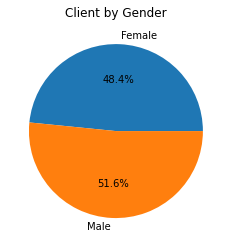

In [63]:
# plot pie chart - level 0 - all client by gender
plt.pie(graph01['number'], labels=graph01['gender'], autopct='%1.1f%%')
plt.title('Client by Gender')
plt.show()

In [64]:
# age group  for account owner open their bank account before 1996
graph02 = sqldf("""
SELECT age_group, count(account_id) AS number
FROM basetable 
GROUP BY age_group
ORDER BY age_group
""")

graph02

,age_group,number
0,10,215
1,20,433
2,30,413
3,40,398
4,50,388
5,60,221
6,70,171


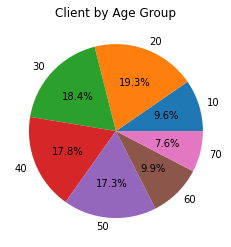

In [65]:
# plot pie chart - level 0 - all client by age_group
plt.pie(graph02['number'], labels=graph02['age_group'], autopct='%1.1f%%')
plt.title('Client by Age Group')
plt.show()

In [66]:
# gender by age group  for account owner open their bank account before 1996
graph03 = sqldf("""
SELECT age_group, gender, count(account_id) AS number
FROM basetable 
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph03 = graph03.pivot(index='age_group', columns='gender', values='number')
graph03 = pd.concat([graph03], axis=1).reset_index()
graph03 = graph03.fillna(0)
graph03.index.name = None

graph03

gender,age_group,Female,Male
0,10,96,119
1,20,239,194
2,30,201,212
3,40,203,195
4,50,188,200
5,60,92,129
6,70,65,106


<AxesSubplot:title={'center':'Client By Age Group'}, xlabel='age_group'>

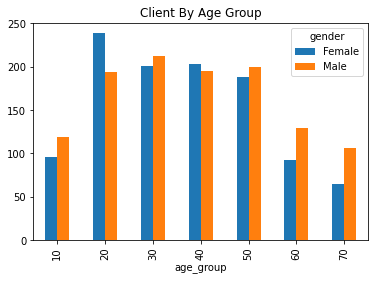

In [67]:
# plot grouped bar chart - level 1 - all client by age_group by gender
graph03.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Client By Age Group')

In [68]:
# gender by region  for account owner open their bank account before 1996
graph04 = sqldf("""
SELECT region, gender, count(account_id) AS number
FROM basetable 
GROUP BY region, gender
ORDER BY region, gender
""")

graph04 = graph04.pivot(index='region', columns='gender', values='number')
graph04 = pd.concat([graph04], axis=1).reset_index()
graph04.index.name = None

graph04

gender,region,Female,Male
0,Prague,135,137
1,central Bohemia,125,140
2,east Bohemia,134,143
3,north Bohemia,118,117
4,north Moravia,162,221
5,south Bohemia,97,93
6,south Moravia,215,186
7,west Bohemia,98,118


<AxesSubplot:title={'center':'Client By Region'}, xlabel='region'>

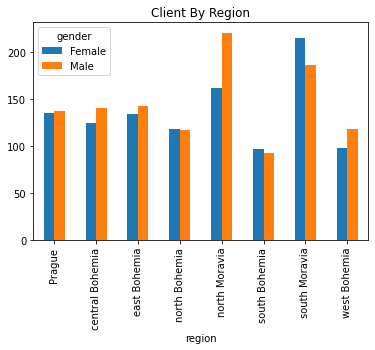

In [69]:
# plot grouped bar chart - level 1 - all client by region by gender
graph04.plot(x='region',
        kind='bar',
        stacked=False,
        title='Client By Region')

## Credit Card Analysis

### Basic information for existing/new credit card owner

In [70]:
# background information for new card owner as at 1996 by gender
graph11_1 = sqldf("""
SELECT gender, sum(have_card_1996) AS number
FROM basetable
GROUP BY gender
ORDER BY gender
""")

graph11_1 = pd.concat([graph11_1], axis=1).reset_index()
graph11_1

,index,gender,number
0,0,Female,46.0
1,1,Male,60.0


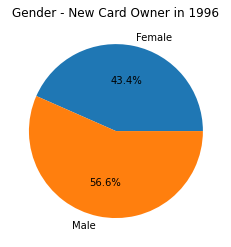

In [71]:
# plot pie chart - level 0 - all new credit client by gender
plt.pie(graph11_1['number'], labels=graph11_1['gender'], autopct='%1.1f%%')
plt.title('Gender - New Card Owner in 1996')
plt.show()

In [72]:
# background information for 1997 new card owner as at 1996 by gender
graph11_2 = sqldf("""
SELECT gender, sum(new_card_1997) AS number
FROM basetable
GROUP BY gender
ORDER BY gender
""")

graph11_2 = pd.concat([graph11_2], axis=1).reset_index()
graph11_2

,index,gender,number
0,0,Female,48.0
1,1,Male,72.0


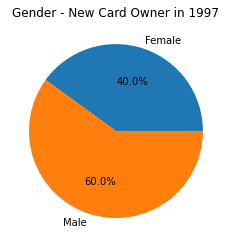

In [73]:
# plot pie chart - level 0 - all new credit client by gender
plt.pie(graph11_2['number'], labels=graph11_2['gender'], autopct='%1.1f%%')
plt.title('Gender - New Card Owner in 1997')
plt.show()

In [74]:
# background information for new card owner as at 1996 by age group
graph12_1 = sqldf("""
SELECT age_group, sum(have_card_1996) AS number
FROM basetable 
GROUP BY age_group
ORDER BY age_group
""")

graph12_1

,age_group,number
0,10,21.0
1,20,23.0
2,30,22.0
3,40,24.0
4,50,9.0
5,60,6.0
6,70,1.0


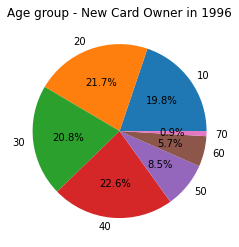

In [75]:
# plot pie chart - level 0 - all new card client by age_group
plt.pie(graph12_1['number'], labels=graph12_1['age_group'], autopct='%1.1f%%')
plt.title('Age group - New Card Owner in 1996')
plt.show()

In [76]:
# background information for 1997 new card owner as at 1996 by age group
graph12_2 = sqldf("""
SELECT age_group, sum(new_card_1997) AS number
FROM basetable 
GROUP BY age_group
ORDER BY age_group
""")

graph12_2

,age_group,number
0,10,9.0
1,20,25.0
2,30,19.0
3,40,28.0
4,50,35.0
5,60,3.0
6,70,1.0


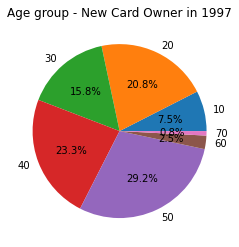

In [77]:
# plot pie chart - level 0 - all new card client by age_group
plt.pie(graph12_2['number'], labels=graph12_2['age_group'], autopct='%1.1f%%')
plt.title('Age group - New Card Owner in 1997')
plt.show()

In [78]:
# background information for new card owner as at 1996 by age group by gender
graph13_1 = sqldf("""
SELECT age_group, gender, sum(have_card_1996) AS number
FROM basetable
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph13_1 = graph13_1.pivot(index='age_group', columns='gender', values='number')
graph13_1 = pd.concat([graph13_1], axis=1).reset_index()
graph13_1 = graph13_1.fillna(0)
graph13_1

gender,age_group,Female,Male
0,10,11.0,10.0
1,20,10.0,13.0
2,30,6.0,16.0
3,40,13.0,11.0
4,50,4.0,5.0
5,60,1.0,5.0
6,70,1.0,0.0


<AxesSubplot:title={'center':'Client Age Group & Gender - New Card Owner in 1996'}, xlabel='age_group'>

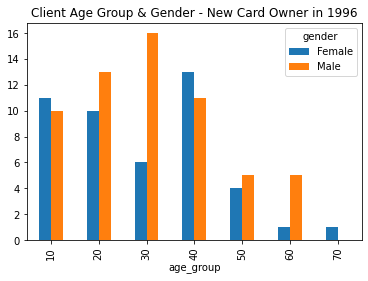

In [79]:
# plot grouped bar chart - level 0 - all new card owner as at 31 Dec 1996
graph13_1.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Client Age Group & Gender - New Card Owner in 1996')

In [80]:
# background information for new card owner in 1997 by age group by gender
graph13_2 = sqldf("""
SELECT age_group, gender, sum(new_card_1997) AS number
FROM basetable
WHERE new_card_1997 = 1
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph13_2 = graph13_2.pivot(index='age_group', columns='gender', values='number')
graph13_2 = pd.concat([graph13_2], axis=1).reset_index()
graph13_2 = graph13_2.fillna(0)
graph13_2

gender,age_group,Female,Male
0,10,0.0,9.0
1,20,15.0,10.0
2,30,8.0,11.0
3,40,9.0,19.0
4,50,16.0,19.0
5,60,0.0,3.0
6,70,0.0,1.0


<AxesSubplot:title={'center':'Client Age Group & Gender - New Card Owner in 1997'}, xlabel='age_group'>

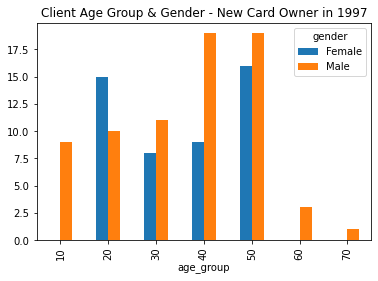

In [81]:
# plot grouped bar chart - level 0 - new card issued in 1997
graph13_2.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Client Age Group & Gender - New Card Owner in 1997')

In [82]:
# gender by region  for new credit card owner
graph14_1 = sqldf("""
SELECT region, gender, sum(have_card_1996) AS number
FROM basetable 
GROUP BY region, gender
ORDER BY region, gender
""")

graph14_1 = graph14_1.pivot(index='region', columns='gender', values='number')
graph14_1 = pd.concat([graph14_1], axis=1).reset_index()
graph14_1.index.name = None

graph14_1

gender,region,Female,Male
0,Prague,6.0,3.0
1,central Bohemia,7.0,7.0
2,east Bohemia,3.0,9.0
3,north Bohemia,9.0,10.0
4,north Moravia,1.0,9.0
5,south Bohemia,8.0,5.0
6,south Moravia,7.0,8.0
7,west Bohemia,5.0,9.0


<AxesSubplot:title={'center':'Client By Region'}, xlabel='region'>

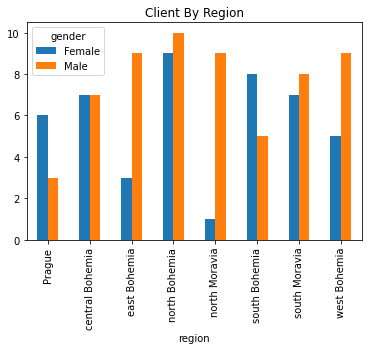

In [83]:
# plot grouped bar chart - level 1 - all new card client by region by gender
graph14_1.plot(x='region',
        kind='bar',
        stacked=False,
        title='Client By Region')

In [84]:
# gender by region  for new credit card owner
graph14_2 = sqldf("""
SELECT region, gender, sum(new_card_1997) AS number
FROM basetable 
GROUP BY region, gender
ORDER BY region, gender
""")

graph14_2 = graph14_2.pivot(index='region', columns='gender', values='number')
graph14_2 = pd.concat([graph14_2], axis=1).reset_index()
graph14_2.index.name = None

graph14_2

gender,region,Female,Male
0,Prague,6.0,9.0
1,central Bohemia,4.0,14.0
2,east Bohemia,9.0,8.0
3,north Bohemia,8.0,7.0
4,north Moravia,6.0,14.0
5,south Bohemia,7.0,1.0
6,south Moravia,6.0,11.0
7,west Bohemia,2.0,8.0


<AxesSubplot:title={'center':'Client By Region'}, xlabel='region'>

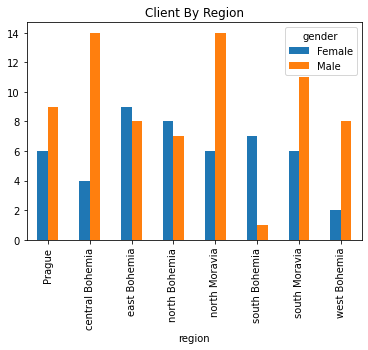

In [85]:
# plot grouped bar chart - level 1 - all new card client by region by gender
graph14_2.plot(x='region',
        kind='bar',
        stacked=False,
        title='Client By Region')

### Spending Habit for New Credit Card Owner in 1996/1997

In [86]:
# spending habit for 1996 new card owner in 1996
graph15_1 = sqldf("""
SELECT age_group, gender, sum(Amount_withdrawal)/sum(have_card_1996) AS credit_card_spending_ratio
FROM basetable 
WHERE have_card_1996 = 1
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph15_1 = graph15_1.pivot(index='age_group', columns='gender', values='credit_card_spending_ratio')
graph15_1 = pd.concat([graph15_1], axis=1).reset_index()
graph15_1 = graph15_1.fillna(0)
graph15_1

gender,age_group,Female,Male
0,10,365869.400000,236292.160000
1,20,356883.070000,314971.707692
2,30,212328.000000,385842.800000
3,40,419504.307692,241721.854545
4,50,328526.000000,383701.200000
5,60,83189.200000,301559.200000
6,70,48797.200000,0.000000


<AxesSubplot:title={'center':'Average Spending in 1996 - New Card Owner in 1996'}, xlabel='age_group'>

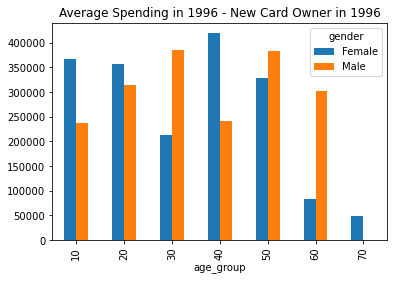

In [87]:
# plot grouped bar chart - level 1 - credit client average yearly spending
graph15_1.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Average Spending in 1996 - New Card Owner in 1996')

In [88]:
# spending habit for 1997 new card owner in 1996
graph15_2 = sqldf("""
SELECT age_group, gender, sum(Amount_withdrawal)/sum(new_card_1997) AS avg_spending
FROM basetable 
WHERE new_card_1997 = 1
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph15_2 = graph15_2.pivot(index='age_group', columns='gender', values='avg_spending')
graph15_2 = pd.concat([graph15_2], axis=1).reset_index()
graph15_2 = graph15_2.fillna(0)
graph15_2

gender,age_group,Female,Male
0,10,0.000000,303807.977778
1,20,277968.506667,336620.360000
2,30,315225.225000,464626.472727
3,40,438046.100000,269024.284211
4,50,291419.006250,256190.484211
5,60,0.000000,462644.333333
6,70,0.000000,53127.200000


<AxesSubplot:title={'center':'Average Spending in 1996 - New Card Owner in 1997'}, xlabel='age_group'>

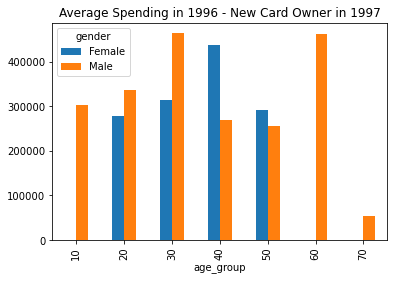

In [89]:
# plot grouped bar chart - level 1 - credit client average yearly credit card spending
graph15_2.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Average Spending in 1996 - New Card Owner in 1997')

### Spending habit by card type (new card in 1996 only)

In [90]:
# credit card spending habit to total spending ratio for new card owner in 1996
graph16 = sqldf("""
SELECT age_group, gender, sum(Credit_Card_withdrawl)/sum(Amount_withdrawal) AS credit_card_spending_ratio
FROM basetable 
WHERE have_card_1996 = 1
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph16 = graph16.pivot(index='age_group', columns='gender', values='credit_card_spending_ratio')
graph16 = pd.concat([graph16], axis=1).reset_index()
graph16 = graph16.fillna(0)
graph16

gender,age_group,Female,Male
0,10,0.017840,0.018833
1,20,0.016084,0.019196
2,30,0.034695,0.010173
3,40,0.011735,0.029485
4,50,0.010730,0.004900
5,60,0.079337,0.023544
6,70,0.151648,0.000000


<AxesSubplot:title={'center':'Credit Card Spending Ratio at 31 Dec 1996 - New Card Owner'}, xlabel='age_group'>

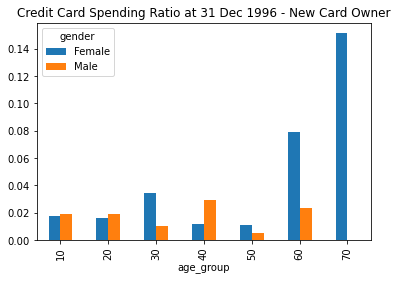

In [91]:
# plot grouped bar chart - level 1 - new credit card spending to total spending ratio
graph16.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Credit Card Spending Ratio at 31 Dec 1996 - New Card Owner')

In [92]:
# credit card spending habit for new card owner in 1996
graph17 = sqldf("""
SELECT client_age, card_type, Credit_Card_withdrawl AS spending
FROM basetable
WHERE have_card_1996 = 1
ORDER BY client_age, card_type
""")

graph17 = graph17[graph17['card_type'] != '0']
graph17

,client_age,card_type,spending
0,14,junior,4800.0
1,14,junior,4700.0
2,14,junior,1800.0
3,15,junior,17100.0
4,16,junior,5900.0
...,...,...,...
101,61,classic,3700.0
102,61,classic,6100.0
103,61,classic,8100.0
104,67,classic,6600.0


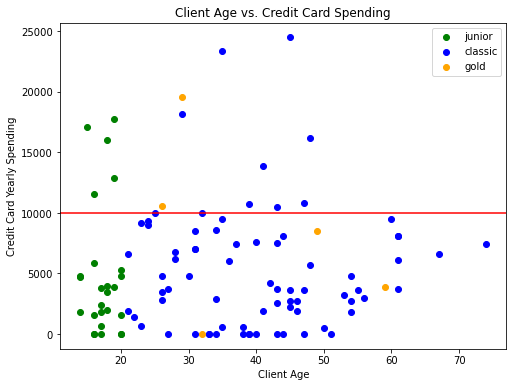

In [93]:
# plot scatter plot - level 2 - client age vs credit card spending
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(graph17[graph17['card_type'] == 'junior']['client_age'],
                 graph17[graph17['card_type'] == 'junior']['spending'], color='green', label='junior')
ax.scatter(graph17[graph17['card_type'] == 'classic']['client_age'],
                 graph17[graph17['card_type'] == 'classic']['spending'], color='blue', label='classic')
ax.scatter(graph17[graph17['card_type'] == 'gold']['client_age'],
                 graph17[graph17['card_type'] == 'gold']['spending'], color='orange', label='gold')

ax.axhline(y=10000, color='r', linestyle='-')

ax.set_xlabel('Client Age')
ax.set_ylabel('Credit Card Yearly Spending')
ax.set_title('Client Age vs. Credit Card Spending')
ax.legend()

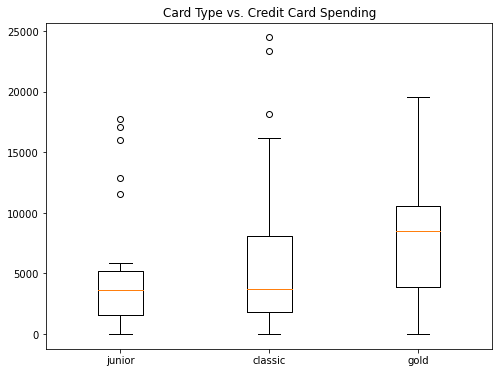

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bpm = ax.boxplot([
    graph17.loc[graph17.card_type == 'junior', 'spending'].values,
    graph17.loc[graph17.card_type == 'classic', 'spending'].values,
    graph17.loc[graph17.card_type == 'gold', 'spending'].values,
])
plt.xticks([1, 2, 3],['junior','classic','gold'])
ax.set_title('Card Type vs. Credit Card Spending')
plt.show()

In [95]:
# credit card spending ratio for existing card owner in 1996
graph18 = sqldf("""
SELECT client_age, card_type, Credit_Card_withdrawl/Amount_withdrawal*100 AS credit_card_spending_ratio
FROM basetable
WHERE have_card_1996 = 1
ORDER BY client_age, card_type
""")

graph18 = graph18[graph18['card_type'] != '0']
graph18

,client_age,card_type,credit_card_spending_ratio
0,14,junior,8.683822
1,14,junior,4.804488
2,14,junior,1.742498
3,15,junior,31.076670
4,16,junior,1.136887
...,...,...,...
101,61,classic,1.153902
102,61,classic,2.536982
103,61,classic,2.761346
104,67,classic,7.933722


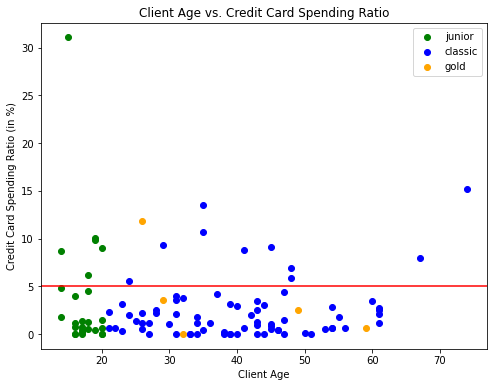

In [96]:
# plot scatter plot - level 2 - client age vs credit card spending
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(graph18[graph18['card_type'] == 'junior']['client_age'],
                 graph18[graph18['card_type'] == 'junior']['credit_card_spending_ratio'], color='green', label='junior')
ax.scatter(graph18[graph18['card_type'] == 'classic']['client_age'],
                 graph18[graph18['card_type'] == 'classic']['credit_card_spending_ratio'], color='blue', label='classic')
ax.scatter(graph18[graph18['card_type'] == 'gold']['client_age'],
                 graph18[graph18['card_type'] == 'gold']['credit_card_spending_ratio'], color='orange', label='gold')

ax.axhline(y=5, color='r', linestyle='-')

ax.set_xlabel('Client Age')
ax.set_ylabel('Credit Card Spending Ratio (in %)')
ax.set_title('Client Age vs. Credit Card Spending Ratio')
ax.legend()

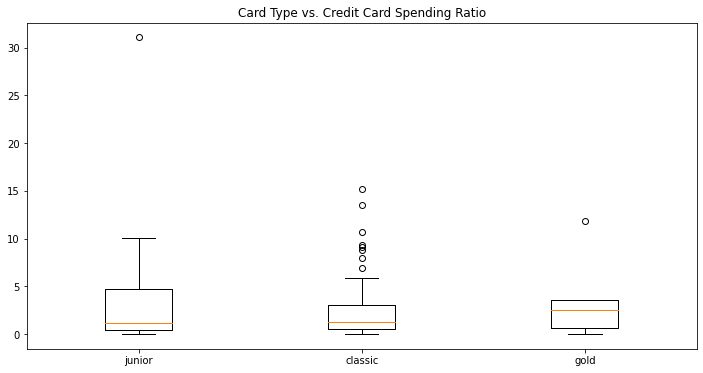

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
bpm = ax.boxplot([
    graph18.loc[graph18.card_type == 'junior', 'credit_card_spending_ratio'].values,
    graph18.loc[graph18.card_type == 'classic', 'credit_card_spending_ratio'].values,
    graph18.loc[graph18.card_type == 'gold', 'credit_card_spending_ratio'].values
])
plt.xticks([1, 2, 3],['junior','classic','gold'])
ax.set_title('Card Type vs. Credit Card Spending Ratio')
plt.show()

## Loan Analysis

### Loan History Status -> For loan contract ended as at 31 Dec 1996

In [98]:
# background information for new loan in 1996 by gender
graph20_1 = sqldf("""
SELECT loan_repayment_history, gender, count(loan_id) AS number
FROM basetable
GROUP BY loan_repayment_history, gender
ORDER BY loan_repayment_history, gender
""")

graph20_1 = graph20_1.pivot(index='loan_repayment_history', columns='gender', values='number')
graph20_1 = pd.concat([graph20_1], axis=1).reset_index()
graph20_1

# The loan status shown on the loan table is confirmed the earlier date of the end contract date or 31/12/1998.
# As we are working on the timeline for 31 Dec 1996, some of the open contracts at that time may have different repayment condition status at the end
# e.g. One client may have OK status at the end of 1996 but could not repay the rest in 1997
# Since these kind of cases are ambiguous, we can only suggest that when promoting the loan, we should include those with good_record and exclude those with default_record

gender,loan_repayment_history,Female,Male
0,default_record,8,1
1,good_record,37,35
2,no_(end)_loan_history,1039,1119


### Basic information for existing/new loan owner

In [99]:
# background information for new loan in 1996 by gender
graph21_1 = sqldf("""
SELECT gender, count(loan_id) AS number
FROM basetable
WHERE loan_id != 0
GROUP BY gender
ORDER BY gender
""")

graph21_1 = pd.concat([graph21_1], axis=1).reset_index()
graph21_1

,index,gender,number
0,0,Female,42
1,1,Male,42


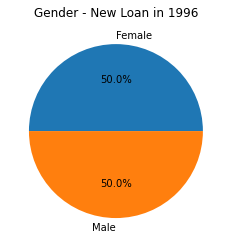

In [100]:
# plot pie chart - level 0 - all new loan in 1996 by gender
plt.pie(graph21_1['number'], labels=graph21_1['gender'], autopct='%1.1f%%')
plt.title('Gender - New Loan in 1996')
plt.show()

In [101]:
# background information for new loan in 1996 by gender
graph21_2 = sqldf("""
SELECT gender, sum(new_loan_1997) AS number
FROM basetable
WHERE new_loan_1997=1
GROUP BY gender
ORDER BY gender
""")

graph21_2 = pd.concat([graph21_2], axis=1).reset_index()
graph21_2

,index,gender,number
0,0,Female,17.0
1,1,Male,14.0


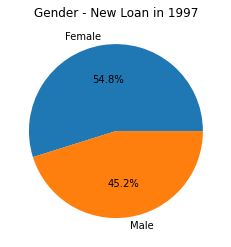

In [102]:
# plot pie chart - level 0 - all new loan in 1997 by gender
plt.pie(graph21_2['number'], labels=graph21_2['gender'], autopct='%1.1f%%')
plt.title('Gender - New Loan in 1997')
plt.show()

In [103]:
# background information for new loan owner in 1996 by age group
graph22_1 = sqldf("""
SELECT age_group, count(loan_id) AS number
FROM basetable
WHERE loan_id != 0
GROUP BY age_group
ORDER BY age_group
""")

graph22_1

,age_group,number
0,10,8
1,20,21
2,30,21
3,40,16
4,50,16
5,60,2


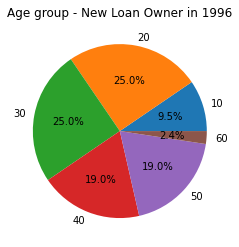

In [104]:
# plot pie chart - level 0 - all new loan owner in 1996 by age_group
plt.pie(graph22_1['number'], labels=graph22_1['age_group'], autopct='%1.1f%%')
plt.title('Age group - New Loan Owner in 1996')
plt.show()

In [105]:
# background information for new loan owner in 1997 by age group
graph22_2 = sqldf("""
SELECT age_group, sum(new_loan_1997) AS number
FROM basetable
WHERE new_loan_1997 = 1
GROUP BY age_group
ORDER BY age_group
""")

graph22_2

,age_group,number
0,10,2.0
1,20,6.0
2,30,9.0
3,40,6.0
4,50,7.0
5,60,1.0


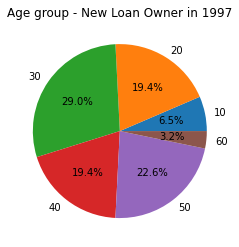

In [106]:
# plot pie chart - level 0 - all new loan owner in 1997 by age_group
plt.pie(graph22_2['number'], labels=graph22_2['age_group'], autopct='%1.1f%%')
plt.title('Age group - New Loan Owner in 1997')
plt.show()

In [107]:
# background information for new loan owner in 1996 by age group by gender
graph23_1 = sqldf("""
SELECT age_group, gender, count(loan_id) AS number
FROM basetable
WHERE loan_id != 0
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph23_1 = graph23_1.pivot(index='age_group', columns='gender', values='number')
graph23_1 = pd.concat([graph23_1], axis=1).reset_index()
graph23_1 = graph23_1.fillna(0)
graph23_1

gender,age_group,Female,Male
0,10,4.0,4.0
1,20,12.0,9.0
2,30,9.0,12.0
3,40,10.0,6.0
4,50,7.0,9.0
5,60,0.0,2.0


<AxesSubplot:title={'center':'Client Age Group & Gender - New Loan Owner in 1996'}, xlabel='age_group'>

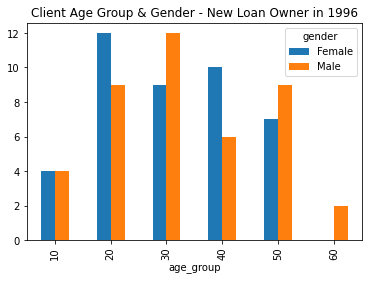

In [108]:
# plot grouped bar chart - level 0 - all new loan owner in 1996
graph23_1.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Client Age Group & Gender - New Loan Owner in 1996')

In [109]:
# background information for new loan owner in 1997 by age group by gender
graph23_2 = sqldf("""
SELECT age_group, gender, sum(new_loan_1997) AS number
FROM basetable
WHERE new_loan_1997 = 1
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph23_2 = graph23_2.pivot(index='age_group', columns='gender', values='number')
graph23_2 = pd.concat([graph23_2], axis=1).reset_index()
graph23_2 = graph23_2.fillna(0)
graph23_2

gender,age_group,Female,Male
0,10,2.0,0.0
1,20,3.0,3.0
2,30,5.0,4.0
3,40,2.0,4.0
4,50,5.0,2.0
5,60,0.0,1.0


<AxesSubplot:title={'center':'Client Age Group & Gender - New Loan Owner in 1997'}, xlabel='age_group'>

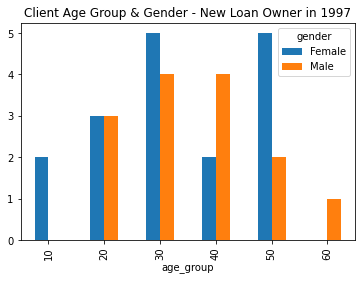

In [110]:
# plot grouped bar chart - level 0 - all new loan owner in 1997
graph23_2.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Client Age Group & Gender - New Loan Owner in 1997')

In [111]:
# gender by region  for new loan owner in 1996
graph24_1 = sqldf("""
SELECT region, gender, count(loan_id) AS number
FROM basetable
WHERE loan_id != 0
GROUP BY region, gender
ORDER BY region, gender
""")

graph24_1 = graph24_1.pivot(index='region', columns='gender', values='number')
graph24_1 = pd.concat([graph24_1], axis=1).reset_index()
graph24_1.index.name = None

graph24_1

gender,region,Female,Male
0,Prague,2,4
1,central Bohemia,6,5
2,east Bohemia,7,5
3,north Bohemia,4,4
4,north Moravia,5,8
5,south Bohemia,6,3
6,south Moravia,8,10
7,west Bohemia,4,3


<AxesSubplot:title={'center':'Client By Region'}, xlabel='region'>

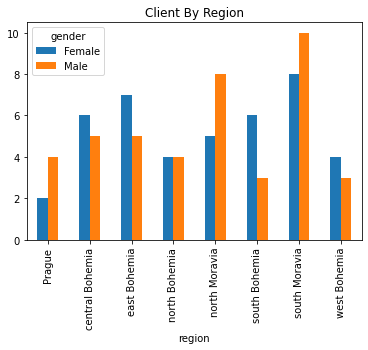

In [112]:
# plot grouped bar chart - level 1 - all new loan client in 1996 by region by gender
graph24_1.plot(x='region',
        kind='bar',
        stacked=False,
        title='Client By Region')

In [113]:
# gender by region  for new loan owner in 1996
graph24_2 = sqldf("""
SELECT region, gender, sum(new_loan_1997) AS number
FROM basetable
WHERE new_loan_1997 = 1
GROUP BY region, gender
ORDER BY region, gender
""")

graph24_2 = graph24_2.pivot(index='region', columns='gender', values='number')
graph24_2 = pd.concat([graph24_2], axis=1).reset_index()
graph24_2 = graph24_2.fillna(0)
graph24_2.index.name = None

graph24_2

gender,region,Female,Male
0,Prague,1.0,1.0
1,central Bohemia,2.0,2.0
2,east Bohemia,2.0,4.0
3,north Bohemia,2.0,0.0
4,north Moravia,2.0,2.0
5,south Bohemia,1.0,1.0
6,south Moravia,4.0,4.0
7,west Bohemia,3.0,0.0


<AxesSubplot:title={'center':'Client By Region'}, xlabel='region'>

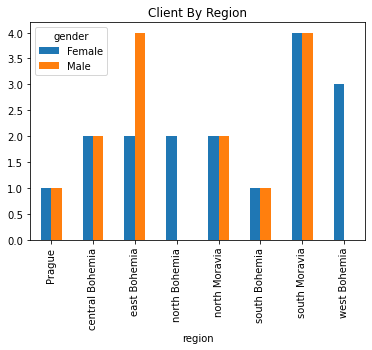

In [114]:
# plot grouped bar chart - level 1 - all new loan client in 1997 by region by gender
graph24_2.plot(x='region',
        kind='bar',
        stacked=False,
        title='Client By Region')

### Net movement for New Loan Owner in 1996/1997

In [115]:
# Average net movement of the bank in 1996 - New Loan Owner in 1996
graph25_1 = sqldf("""
SELECT age_group, gender, sum(Amount_credit-Amount_withdrawal)/count(loan_id) AS net_movement
FROM basetable
WHERE loan_id != 0
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph25_1 = graph25_1.pivot(index='age_group', columns='gender', values='net_movement')
graph25_1 = pd.concat([graph25_1], axis=1).reset_index()
graph25_1.index.name = None
graph25_1 = graph25_1.fillna(0)
graph25_1

gender,age_group,Female,Male
0,10,-2709.600000,-12207.250000
1,20,-5012.700000,-5500.666667
2,30,-4699.600000,-6443.591667
3,40,3302.320000,16594.633333
4,50,-10151.828571,3979.544444
5,60,0.000000,3.000000


<AxesSubplot:title={'center':'Average net movement - New Loan Owner in 1996'}, xlabel='age_group'>

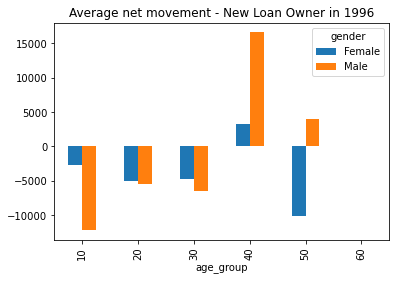

In [116]:
# plot grouped bar chart - level 1 - Average net movement of the bank in 1996 - New Loan Owner in 1996 by age group by gender
graph25_1.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Average net movement - New Loan Owner in 1996')

In [117]:
# Average net movement of the bank in 1996 - New Loan Owner in 1997
graph25_2 = sqldf("""
SELECT age_group, gender, sum(Amount_credit-Amount_withdrawal)/sum(new_loan_1997) AS net_movement
FROM basetable
WHERE new_loan_1997 = 1
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph25_2 = graph25_2.pivot(index='age_group', columns='gender', values='net_movement')
graph25_2 = pd.concat([graph25_2], axis=1).reset_index()
graph25_2.index.name = None
graph25_2 = graph25_2.fillna(0)
graph25_2

gender,age_group,Female,Male
0,10,-16011.700000,0.00
1,20,7873.766667,-25425.60
2,30,-3153.740000,-8617.40
3,40,-20817.900000,3396.40
4,50,8295.520000,12986.35
5,60,0.000000,34611.80


<AxesSubplot:title={'center':'Average net movement - New Loan Owner in 1997'}, xlabel='age_group'>

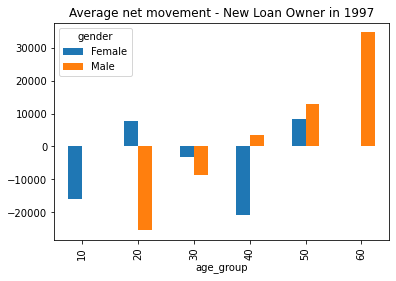

In [118]:
# plot grouped bar chart - level 1 - Average net movement of the bank in 1996 - New Loan Owner in 1996 by age group by gender
graph25_2.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Average net movement - New Loan Owner in 1997')

### Loan info (Loan duration, repayment) (new loan in 1996 only)

In [119]:
# Loan duration by gender - New loan in 1996
graph26 = sqldf("""
SELECT gender, duration_year, count(loan_id) AS number
FROM basetable
WHERE loan_id != 0
GROUP BY duration_year, gender
ORDER BY duration_year, gender
""")

graph26 = graph26.pivot(index='duration_year', columns='gender', values='number')
graph26 = pd.concat([graph26], axis=1).reset_index()
graph26.index.name = None
graph26 = graph26.fillna(0)
graph26

gender,duration_year,Female,Male
0,1.0,6,2
1,2.0,8,8
2,3.0,7,9
3,4.0,10,12
4,5.0,11,11


<AxesSubplot:title={'center':'Loan Duration - New Loan Owner in 1996'}, xlabel='duration_year'>

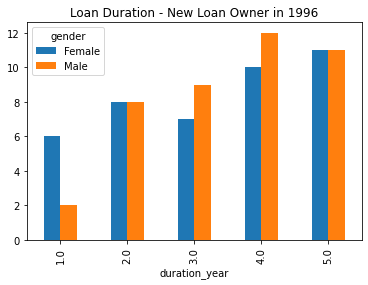

In [120]:
# plot grouped bar chart - level 1 - Loan duration by gender
graph26.plot(x='duration_year',
        kind='bar',
        stacked=False,
        title='Loan Duration - New Loan Owner in 1996')

In [121]:
# Loan duration by age_grpoup - New loan in 1996
graph27 = sqldf("""
SELECT age_group, duration_year, count(loan_id) AS number
FROM basetable
WHERE loan_id != 0
GROUP BY duration_year, age_group
ORDER BY duration_year, age_group
""")

graph27 = graph27.pivot(index='duration_year', columns='age_group', values='number')
graph27 = pd.concat([graph27], axis=1).reset_index()
graph27.index.name = None
graph27 = graph27.fillna(0)
graph27

age_group,duration_year,10,20,30,40,50,60
0,1.0,1.0,2.0,0.0,2.0,3.0,0.0
1,2.0,1.0,3.0,6.0,1.0,4.0,1.0
2,3.0,1.0,4.0,4.0,3.0,4.0,0.0
3,4.0,2.0,6.0,5.0,6.0,2.0,1.0
4,5.0,3.0,6.0,6.0,4.0,3.0,0.0


<AxesSubplot:title={'center':'Loan Duration - New Loan Owner in 1996'}, xlabel='duration_year'>

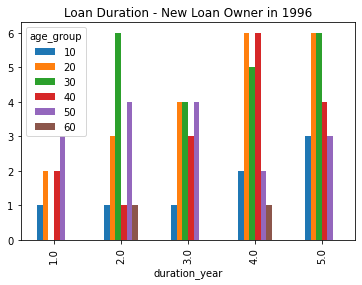

In [122]:
# plot grouped bar chart - level 1 - Loan duration by age_grpoup
graph27.plot(x='duration_year',
        kind='bar',
        stacked=False,
        title='Loan Duration - New Loan Owner in 1996')

In [123]:
# Loan repayment to spending ratio - New loan in 1996
graph28 = sqldf("""
SELECT age_group, gender, sum(Loan_payment)/sum(Amount_withdrawal)*100 AS payment_ratio
FROM basetable 
GROUP BY age_group, gender
ORDER BY age_group, gender
""")

graph28 = graph28.pivot(index='age_group', columns='gender', values='payment_ratio')
graph28 = pd.concat([graph28], axis=1).reset_index()
graph28 = graph28.fillna(0)
graph28

gender,age_group,Female,Male
0,10,0.203305,0.226145
1,20,0.230892,0.429367
2,30,0.317710,0.143331
3,40,0.128230,0.156603
4,50,0.308979,0.322115
5,60,0.000000,0.163039
6,70,0.000000,0.000000


<AxesSubplot:title={'center':'Loan Repayment to Spending Ratio (in %) - New Loan Owner in 1996'}, xlabel='age_group'>

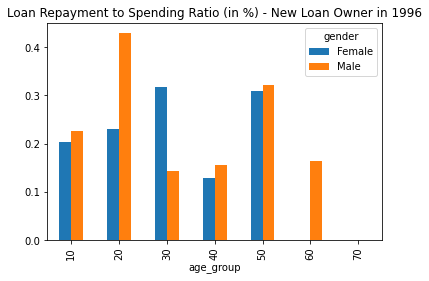

In [124]:
# plot grouped bar chart - level 1 - Loan repayment to spending ratio
graph28.plot(x='age_group',
        kind='bar',
        stacked=False,
        title='Loan Repayment to Spending Ratio (in %) - New Loan Owner in 1996')

In [125]:
# Loan payment
graph29 = sqldf("""
SELECT client_age, gender, Loan_payment AS repayment
FROM basetable
WHERE loan_id != 0
ORDER BY client_age, gender
""")

graph29

,client_age,gender,repayment
0,16,Female,0.0
1,16,Female,0.0
2,16,Female,4750.0
3,16,Male,0.0
4,17,Male,11580.0
...,...,...,...
79,57,Female,6177.0
80,57,Male,0.0
81,57,Male,0.0
82,60,Male,0.0


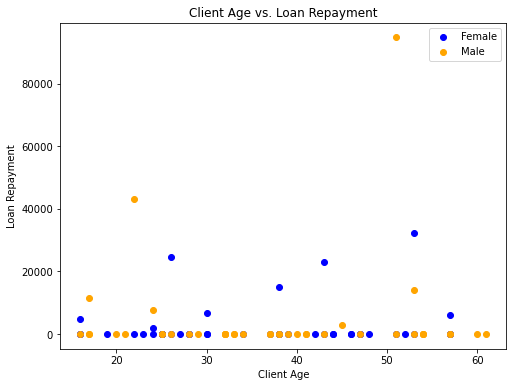

In [126]:
# plot scatter plot - level 2 - client age vs loan repayment
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(graph29[graph29['gender'] == 'Female']['client_age'],
                 graph29[graph29['gender'] == 'Female']['repayment'], color='blue', label='Female')
ax.scatter(graph29[graph29['gender'] == 'Male']['client_age'],
                 graph29[graph29['gender'] == 'Male']['repayment'], color='orange', label='Male')

# ax.axhline(y=20000, color='grey', linestyle='-')

ax.set_xlabel('Client Age')
ax.set_ylabel('Loan Repayment')
ax.set_title('Client Age vs. Loan Repayment')
ax.legend()

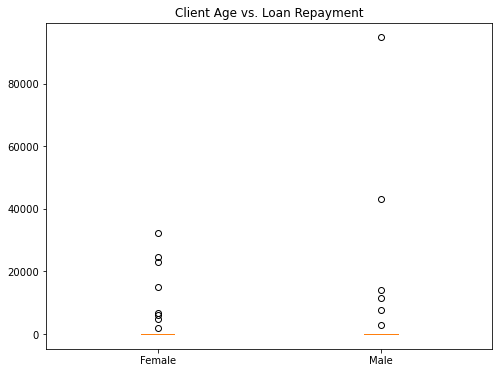

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bpm = ax.boxplot([
    graph29.loc[graph29.gender == 'Female', 'repayment'].values,
    graph29.loc[graph29.gender == 'Male', 'repayment'].values,
])
plt.xticks([1, 2],['Female','Male'])
ax.set_title('Client Age vs. Loan Repayment')
plt.show()